<a href="https://colab.research.google.com/github/ColbyLe/CS499A2/blob/master/499_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title
!mkdir /root/.kaggle
!mkdir .kaggle

import json
token = {"username":"colbyle","key":"f77beaea20746ec9c2d601f26ba19909"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
#@title
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v/content

In [0]:
#@title
!kaggle competitions download -c cs4990-fall2019-assignment-2

In [0]:
#@title
!mv /content/competitions/cs4990*2/test_data.csv.zip /content/test_data.csv.zip
!mv /content/competitions/cs4990*2/train_data.csv.zip /content/train_data.csv.zip
!mv /content/competitions/cs4990*2/train_target.csv /content/train_target.csv
!rm -r competitions

!unzip /content/train_data.csv.zip
!unzip /content/test_data.csv.zip
!rm /content/train_data.csv.zip
!rm /content/test_data.csv.zip

In [0]:
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, GaussianNoise
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

In [0]:
#load data and targets
train_data = np.loadtxt(open("train_data.csv"), delimiter = ",")

train_target = np.loadtxt(open("train_target.csv"), delimiter = ",")

test_data = np.loadtxt(open("test_data.csv"), delimiter = ",")

In [0]:
#@title
toDiv = 0

In [0]:
#@title
if(toDiv == 0):
  train_data /= 255.0
  test_data /= 255.0
  toDiv+=1
  print("Feature scaling complete\n")
else: print("NOPE")

In [0]:
#@title
# display 1 image
im1 = train_data[11119].reshape(48,48)
plt.imshow(im1)
plt.colorbar()

In [0]:
#reshape data to fit model
train_data = train_data.reshape(16175,48,48,1)
test_data = test_data.reshape(3965,48,48,1)

#change target to one-hot encoding
train_target = to_categorical(train_target)


In [0]:
#split data into training and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data, train_target, test_size=0.1, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(14557, 48, 48, 1) (14557, 3)
(1618, 48, 48, 1) (1618, 3)


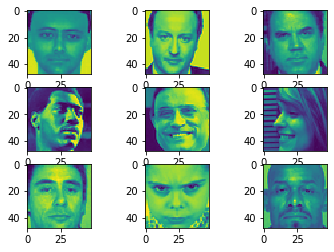

In [0]:
#@title
images = range(0,9)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i].reshape(48,48))

In [0]:
# define initial parameters
num_classes = 3
batch_size = 64
epochs = 100

<br><br><br><br><br>

Data Augmentation

In [0]:
#@title
# simple horizontal flip
datagen = ImageDataGenerator(horizontal_flip=True)

datagen.fit(X_train)

In [0]:
# Generator for augmented image data
moreGen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               zoom_range=[0.9, 1.1],
                               horizontal_flip=True,
                               fill_mode='nearest',
                               data_format='channels_last')

moreGen.fit(X_train)

In [0]:
#@title
extraGen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               #shear_range=0.01,
                               zoom_range=[0.8, 1.3],
                               horizontal_flip=True,
                               #vertical_flip=False,
                              shear_range=0.05
                               fill_mode='nearest',
                               data_format='channels_last')

extraGen.fit(X_train)

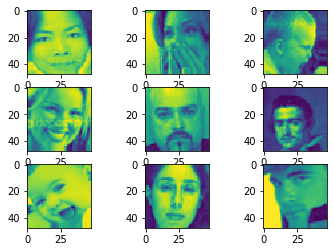

In [0]:
#@title
for X_batch, Y_batch in moreGen.flow(X_train, Y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48))
    # show the plot
    plt.show()
    break

<br><br><br><br><br>

**VGG-Like**<br>

![alt text](https://miro.medium.com/max/1122/1*_1DEx3bHlnBApCWWQ0HgcQ.png)





In [0]:
#@title
# Adapted VGGNet Implementation
# 100 epochs => 76% validation accuracy
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(Dropout(0.4))
model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.name = 'VGG-Like'

model.compile(optimizer=SGD'sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
dropout_9 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 64)       

**CCNN**<br>

In [0]:
drop = 0.5

![alt text](https://docs.google.com/uc?export=download&id=1JmzBI5paU5cNFwtTir4o8agnPTIr8vnB)

In [0]:
# Initial configuration
# 100 epochs => 77% validation accuracy
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(drop))

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(drop))


model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.name = 'CCNN'

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 32)        6176      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 64)         

![alt text](https://docs.google.com/uc?export=download&id=1lpIx7N9sV1Fbn23nDxT9Y_eqSZW2xNTq)

In [0]:
# Doubled convolutional filters
# 500 epochs => ~79% testing accuracy
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(drop))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(drop))


model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.name = 'CCNN'
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 64)        24640     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 128)        

**CCNN w/ Batch Normalization**

![alt text](https://docs.google.com/uc?export=download&id=1LvSF3VD4_b7ejwU8hH1XHF7rI62xXo70)

In [0]:
# 1550 epochs => ~81% testing accuracy
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))


model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.name = 'CCNN + Batch Normalization'

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=(['accuracy']))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 64)        24640     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 128)      

**CCNN Dense**

![alt text](https://docs.google.com/uc?export=download&id=1dkFVUvavR8ExkjqzDaH-sCzVvZctoU6i)

In [0]:
# Added another dense layer
# Trained with data augmentation
# 1400 epochs => ~82% testing accuracy when using SGD
# 600 epochs => ~85% testing accuracy when using Adam

model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.name = 'CCNN Dense'

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=(['accuracy']))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 64)        24640     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_23 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 128)      

**CCNN Fully Convolutional**

![alt text](https://docs.google.com/uc?export=download&id=17dJJYISv4pflhKFvXCMLg-0e46HEnqGX)

In [0]:
# Replaced dense layers in previous model with convolutional layers
# Produces same result as with dense layers
# Trained with data augmentation
# 600 epochs => ~85% testing accuracy

model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))


model.add(Conv2D(128, kernel_size=(3,3), strides=1, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(3, kernel_size=(1,1), strides=1, activation='softmax'))
model.add(Flatten())

model.summary()
model.name = 'CFCN'

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=(['accuracy']))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_26 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 12, 12, 128)      

In [0]:
# Generator for augmented image data
imGen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               zoom_range=[0.9, 1.1],
                               horizontal_flip=True,
                               fill_mode='nearest',
                               data_format='channels_last')

imGen.fit(X_train)

In [0]:
#@title
# ~2000 epochs => ~85.04% validation accuracy

model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))
#model.add(GaussianNoise(0.5))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))
#model.add(GaussianNoise(0.5))

model.add(Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop))
#model.add(GaussianNoise(0.5))

#model.add(Flatten())
model.add(Conv2D(256, kernel_size=(3,3), strides=1, activation='relu'))
#model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(3, kernel_size=(1,1), strides=1, activation='softmax'))
model.add(Flatten())
#model.add(Dense(num_classes, activation='softmax'))

model.summary()

mName = 'Troika++'

In [0]:
#@title
# v1.1: added batch normalization layers before dropout layers
# added more layers between flatten layer and output layer
# Train using ~1409 epochs
# Yields ~81% testing accuracy
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))
model.add(GaussianNoise(0.3))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))
model.add(GaussianNoise(0.3))

#model.add(Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(drop))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

mName = 'Troika Noisy Dense'

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=(['accuracy']))

<br><br><br><br><br>
# **Training Section**

In [0]:
drop = 0.5
num_classes = 3
batch_size = 64
epochs = 1600

In [0]:
#@title
model.compile(optimizer=SGD(lr=0.005, momentum=0.5, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#@title
print(mName, '\n')
history = model.fit(np.array(X_train), np.array(Y_train), 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(np.array(X_valid), np.array(Y_valid)), 
          shuffle = True)

In [0]:
#@title
model.load_weights('Troika Dense')

In [0]:
#@title
# train with simple horizontal flip augmentation
print(model.name, '\n', 'Horizontal Flip\n')
history = model.fit_generator(datagen.flow(X_train, Y_train),
                    steps_per_epoch=14557//batch_size,
                    epochs=2500,
                    verbose=1,
                    validation_data=(datagen.flow(X_valid, Y_valid)))

In [0]:
# train with full augmentation
print(model.name, '\n', 'Full Augmentation\n')
model.fit_generator(moreGen.flow(X_train, Y_train),
                    steps_per_epoch=14557//batch_size,
                    epochs=2500,
                    verbose=1,
                    validation_data=(X_valid, Y_valid))

Troika Noisy Dense 
 Full Augmentation

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2500
227/227 [==============================] - 11s 49ms/step - loss: 1.2011 - acc: 0.4213 - val_loss: 1.0671 - val_acc: 0.4592
Epoch 2/2500
227/227 [==============================] - 6s 27ms/step - loss: 1.0608 - acc: 0.4566 - val_loss: 1.0506 - val_acc: 0.4691
Epoch 3/2500
227/227 [==============================] - 7s 29ms/step - loss: 1.0173 - acc: 0.4877 - val_loss: 0.9655 - val_acc: 0.5192
Epoch 4/2500
227/227 [==============================] - 6s 28ms/step - loss: 0.9889 - acc: 0.5174 - val_loss: 0.9196 - val_acc: 0.5501
Epoch 5/2500
227/227 [==============================] - 6s 28ms/step - loss: 0.9493 - acc: 0.5426 - val_loss: 0.8518 - val_acc: 0.6069
Epoch 6/2500
227/227 [==============================] - 6s 28ms/step - loss: 0.9076 - acc: 0.5760 - val_loss: 0.7801 - val_acc: 0.6452
Epoch 7/2500
227/227 [==============================]

In [0]:
# train with full augmentation
print(mName, '\n', 'Full Augmentation\n')
model.fit_generator(extraGen.flow(X_train, Y_train),
                    steps_per_epoch=14557//batch_size,
                    epochs=2500,
                    verbose=1,
                    validation_data=(X_valid, Y_valid))

In [0]:
model.save_weights('Troika++ 2300', '.h5')

In [0]:
print(history.history.keys)

# **Best Configuration**<br>
CCNN Dense w/ Adam, moreGen<br>
Should converge to ~84% validation accuracy in ~600 epochs

In [0]:
moreGen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               #shear_range=0.01,
                               zoom_range=[0.9, 1.1],
                               horizontal_flip=True,
                               #vertical_flip=False,
                               fill_mode='nearest',
                               data_format='channels_last')

moreGen.fit(X_train)

In [0]:
# Trained w/ moreGen for about 600 epochs
# Yields >85% testing accuracy
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))

model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(drop))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.name = 'CCNN Dense'

In [0]:
num_classes = 3
batch_size = 64
epochs = 700

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=(['accuracy']))

In [0]:
# train with full augmentation
# this ruins validation accuracy
print(mName, '\n', 'Full Augmentation\n')
model.fit_generator(moreGen.flow(X_train, Y_train),
                    steps_per_epoch=14557//batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_valid, Y_valid))

#**Export Section**
Export results as formatted CSV

In [0]:
test_pred = np.argmax(model.predict(test_data), axis=1)
print(test_pred)

row1=np.arange(len(test_pred))
print(row1)

[2 0 0 ... 1 2 2]
[   0    1    2 ... 3962 3963 3964]


In [0]:
val_pred = np.argmax(model.predict(X_valid), axis=1)
print(val_pred[397])

print(Y_valid[397])

for i in range(len(Y_valid)):
  print(val_pred[i], ' ', Y_valid[i])

0
[0. 0. 1.]
1   [0. 1. 0.]
1   [0. 1. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
2   [0. 0. 1.]
2   [0. 0. 1.]
0   [1. 0. 0.]
0   [1. 0. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
1   [0. 1. 0.]
1   [0. 1. 0.]
2   [0. 0. 1.]
1   [0. 1. 0.]
1   [0. 1. 0.]
1   [0. 1. 0.]
2   [1. 0. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
1   [0. 1. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
0   [0. 0. 1.]
0   [1. 0. 0.]
1   [0. 1. 0.]
2   [0. 0. 1.]
2   [0. 0. 1.]
1   [0. 1. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
2   [0. 0. 1.]
2   [0. 0. 1.]
1   [0. 1. 0.]
0   [1. 0. 0.]
0   [1. 0. 0.]
2   [0. 0. 1.]
1   [0. 1. 0.]
2   [0. 1. 0.]
2   [0. 0. 1.]
1   [0. 1. 0.]
1   [0. 1. 0.]
1   [0. 1. 0.]
2   [0. 0. 1.]
2   [0. 0. 1.]
2   [0. 0. 1.]
2   [0. 0. 1.]
1   [0. 1. 0.]
2   [1. 0. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
1   [0. 1. 0.]
0   [1. 0. 0.]
0   [1. 0. 0.]
1   [0. 1. 0.]
1   [0. 1. 0.]
2   [0. 0. 1.]
1   [0. 1. 0.]
1   [0. 1. 0.]
2   [0. 0. 1.]
1   [0. 1. 0.]
2   [1. 0. 0.]
0   [0. 0. 1.]
1   [0. 1. 0.]
1   [0. 1. 0

In [0]:
res_matx = np.vstack([row1, test_pred]).transpose()
print(res_matx.shape)

(3965, 2)


In [0]:
np.savetxt("res1.csv", res_matx, delimiter=',', fmt='%d')